<p style="align: center;"><img src="https://static.tildacdn.com/tild6636-3531-4239-b465-376364646465/Deep_Learning_School.png" width="400"></p>

# Глубокое обучение. Часть 2
# Домашнее задание по теме "Механизм внимания"

Это домашнее задание проходит в формате peer-review. Это означает, что его будут проверять ваши однокурсники. Поэтому пишите разборчивый код, добавляйте комментарии и пишите выводы после проделанной работы.

В этом задании вы будете решать задачу классификации математических задач по темам (многоклассовая классификация) с помощью Transformer.

В качестве датасета возьмем датасет математических задач по разным темам. Нам необходим следующий файл:

[Файл с классами](https://docs.google.com/spreadsheets/d/13YIbphbWc62sfa-bCh8MLQWKizaXbQK9/edit?usp=drive_link&ouid=104379615679964018037&rtpof=true&sd=true)

**Hint:** не перезаписывайте модели, которые вы получите на каждом из этапов этого дз. Они ещё понадобятся.

In [84]:
import transformers
from transformers import AutoModel, AutoTokenizer
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [ ]:
!gdown 1IMRxByfg7gjoZ5i7rxvuNDvSrbdOJOc-

In [ ]:
!gdown 13YIbphbWc62sfa-bCh8MLQWKizaXbQK9

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
ru_df = pd.read_excel("/content/data_problems.xlsx")
ru_df.drop(columns=["Unnamed: 0"], inplace=True)
ru_df.rename(columns={"Задача": "task", "Тема": "label"}, inplace=True)

label_encoder = LabelEncoder()
ru_df["label"] = label_encoder.fit_transform(ru_df["label"])

In [7]:
train_ru_data, test_ru_data = train_test_split(ru_df, test_size=0.2)

In [ ]:
ru_tokenizer = AutoTokenizer.from_pretrained("cointegrated/rubert-tiny2")
eng_tokenizer = AutoTokenizer.from_pretrained("tbs17/MathBert")

In [9]:
train_ru_task = ru_tokenizer(train_ru_data["task"].to_list(), padding=True,
                             truncation=True, max_length=512, return_tensors="pt")

test_ru_task = ru_tokenizer(test_ru_data["task"].to_list(), padding=True,
                            truncation=True, max_length=512, return_tensors="pt")

In [10]:
train_ru_dataset = TensorDataset(train_ru_task["input_ids"],
                                 train_ru_task["attention_mask"],
                                 train_ru_task["token_type_ids"],
                                 torch.tensor(train_ru_data["label"].values)
                                 )

test_ru_dataset = TensorDataset(test_ru_task["input_ids"],
                                test_ru_task["attention_mask"],
                                test_ru_task["token_type_ids"],
                                torch.tensor(test_ru_data["label"].values)
                                )

In [11]:
train_ru_dataloader = DataLoader(train_ru_dataset, batch_size=32, shuffle=True)
test_ru_dataloader = DataLoader(test_ru_dataset, batch_size=32, shuffle=False)

In [12]:
eng_df = pd.read_excel("/content/data_problems_translated.xlsx")
eng_df.drop(columns=["Unnamed: 0"], inplace=True)
eng_df.rename(columns={"problem_text": "task", "topic": "label"}, inplace=True)
eng_df.dropna(inplace=True)

eng_label_encoder = LabelEncoder()
eng_df["label"] = eng_label_encoder.fit_transform(eng_df["label"])

In [13]:
train_eng_data, test_eng_data = train_test_split(eng_df, test_size=0.2)

In [14]:
train_eng_task = eng_tokenizer(train_eng_data["task"].to_list(), padding=True,
                               truncation=True, max_length=512, return_tensors="pt")

test_eng_task = eng_tokenizer(test_eng_data["task"].to_list(), padding=True,
                              truncation=True, max_length=512, return_tensors="pt")

In [15]:
train_eng_dataset = TensorDataset(train_eng_task["input_ids"],
                                  train_eng_task["attention_mask"],
                                  train_eng_task["token_type_ids"],
                                  torch.tensor(train_eng_data["label"].values)
                                  )

test_eng_dataset = TensorDataset(test_eng_task["input_ids"],
                                 test_eng_task["attention_mask"],
                                 test_eng_task["token_type_ids"],
                                 torch.tensor(test_eng_data["label"].values)
                                 )

In [16]:
train_eng_dataloader = DataLoader(train_eng_dataset, batch_size=32, shuffle=True)
test_eng_dataloader = DataLoader(test_eng_dataset, batch_size=32, shuffle=False)

### Задание 1 (2 балла)

Напишите кастомный класс для модели трансформера для задачи классификации, использующей в качествке backbone какую-то из моделей huggingface.

Т.е. конструктор класса должен принимать на вход название модели и подгружать её из huggingface, а затем использовать в качестве backbone (достаточно возможности использовать в качестве backbone те модели, которые упомянуты в последующих пунктах)

In [17]:
class TransformerClassificationModel(nn.Module):
    def __init__(self, base_transformer_model: str, num_labels: int):
        super().__init__()

        self.backbone = AutoModel.from_pretrained(base_transformer_model)

        hid_dim = self.backbone.config.hidden_size
        self.lin_layer = nn.Linear(hid_dim, num_labels)
        self.dropout = nn.Dropout(0.2)

    def forward(self, input_ids, attention_mask=None, token_type_ids=None):
        logits = self.backbone(input_ids=input_ids,
                               attention_mask=attention_mask,
                               token_type_ids=token_type_ids)

        last_hidden_state = logits.last_hidden_state[:, 0, :]

        logits = self.lin_layer(self.dropout(last_hidden_state))

        outputs = {"logits": logits}
        return outputs

In [18]:
ru_labels = len(ru_df["label"].unique())
eng_labels = len(eng_df["label"].unique())
print(f"В русском датасете {ru_labels} лэйблов")
print(f"В английском датасете {eng_labels} лэйблов")

В русском датасете 7 лэйблов
В английском датасете 7 лэйблов


### Задание 2 (1 балл)

Напишите функцию заморозки backbone у модели (если необходимо, возвращайте из функции модель)

In [19]:
def freeze_backbone_function(model: TransformerClassificationModel):
    for name, param in model.named_parameters():
        if "backbone" in name:
            param.requires_grad = False
        else:
            param.requires_grad = True

### Задание 3 (2 балла)

Напишите функцию, которая будет использована для тренировки (дообучения) трансформера (TransformerClassificationModel). Функция должна поддерживать обучение с замороженным и размороженным backbone.

In [78]:
import copy

def train_transformer(transformer_model, train_loader, test_loader,
                      freeze_backbone=True, n_epochs=5):
    model = copy.copy(transformer_model)
    model.to(device)

    if freeze_backbone:
        freeze_backbone_function(model)

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters())

    losses = []
    accuracy = []
    for epoch in range(n_epochs):
        model.train()
        losses_per_epoch = []
        cur_loss = 0
        for batch in tqdm(train_loader, desc=f"Training {epoch+1} epoch"):
            optimizer.zero_grad()
            input_ids, attention_mask, token_type_ids, label = batch
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            token_type_ids = token_type_ids.to(device)
            label = label.to(device)
            outputs = model(input_ids,
                            attention_mask=attention_mask,
                            token_type_ids=token_type_ids)
            loss = criterion(outputs["logits"], label)
            loss.backward()
            optimizer.step()
            losses_per_epoch.append(loss.item())
            cur_loss += loss.item()

        losses.append(np.mean(losses_per_epoch))

        model.eval()
        test_acc = 0
        with torch.no_grad():
            for batch in test_loader:
                input_ids, attention_mask, token_type_ids, label = batch
                input_ids = input_ids.to(device)
                attention_mask = attention_mask.to(device)
                token_type_ids = token_type_ids.to(device)
                label = label.to(device)
                outputs = model(input_ids,
                                attention_mask=attention_mask,
                                token_type_ids=token_type_ids)
                preds = torch.argmax(outputs["logits"], dim=1)
                test_acc += (preds == label).sum().item() / len(label)

        test_acc /= len(test_loader)
        accuracy.append(test_acc)
        print(f"Train Loss: {losses[-1]} Test accuracy: {accuracy[-1]}")

    return model, losses, accuracy

### Задание 4 (1 балл)

Проверьте вашу функцию из предыдущего пункта, дообучив двумя способами
*cointegrated/rubert-tiny2* из huggingface.

In [86]:
print("Training rubert with freezed backbone")

rubert_tiny_transformer_model = TransformerClassificationModel("cointegrated/rubert-tiny2",
                                                               num_labels=7)
rubert_tiny_finetuned_with_freezed_backbone, losses_freezed_rubert, accuracy_freezed_rubert = train_transformer(rubert_tiny_transformer_model,
                                                                                                                train_ru_dataloader,
                                                                                                                test_ru_dataloader,
                                                                                                                freeze_backbone=True,
                                                                                                                n_epochs=5)
print("---------------------------------------")
print("Training rubert with unfreezed backbone")
print("---------------------------------------")

rubert_tiny_transformer_model = TransformerClassificationModel("cointegrated/rubert-tiny2",
                                                               num_labels=7)
rubert_tiny_full_finetuned, losses_full_rubert, accuracy_full_rubert = train_transformer(rubert_tiny_transformer_model,
                                                                                         train_ru_dataloader,
                                                                                         test_ru_dataloader,
                                                                                         freeze_backbone=False,
                                                                                         n_epochs=5)

Training rubert with freezed backbone


Training 1 epoch: 100%|██████████| 132/132 [00:07<00:00, 18.26it/s]


Train Loss: 1.3803797201676802 Test accuracy: 0.5686400293255132


Training 2 epoch: 100%|██████████| 132/132 [00:06<00:00, 19.13it/s]


Train Loss: 1.1464281953645474 Test accuracy: 0.5867240957966765


Training 3 epoch: 100%|██████████| 132/132 [00:06<00:00, 18.94it/s]


Train Loss: 1.0805036831985821 Test accuracy: 0.6056634897360704


Training 4 epoch: 100%|██████████| 132/132 [00:07<00:00, 18.85it/s]


Train Loss: 1.0540116786053686 Test accuracy: 0.6084738514173997


Training 5 epoch: 100%|██████████| 132/132 [00:07<00:00, 18.58it/s]


Train Loss: 1.037799432873726 Test accuracy: 0.6208150048875856
---------------------------------------
Training rubert with unfreezed backbone
---------------------------------------


Training 1 epoch: 100%|██████████| 132/132 [00:25<00:00,  5.19it/s]


Train Loss: 1.1641896014863795 Test accuracy: 0.6710043988269795


Training 2 epoch: 100%|██████████| 132/132 [00:25<00:00,  5.09it/s]


Train Loss: 0.9202737997878682 Test accuracy: 0.6435422776148583


Training 3 epoch: 100%|██████████| 132/132 [00:25<00:00,  5.10it/s]


Train Loss: 0.7841907586112167 Test accuracy: 0.6510569403714564


Training 4 epoch: 100%|██████████| 132/132 [00:26<00:00,  5.04it/s]


Train Loss: 0.7059488228776238 Test accuracy: 0.5611559139784946


Training 5 epoch: 100%|██████████| 132/132 [00:26<00:00,  5.01it/s]


Train Loss: 0.6603418457688708 Test accuracy: 0.5923448191593352


### Задание 5 (1 балл)

Обучите *tbs17/MathBert* (с замороженным backbone и без заморозки), проанализируйте результаты. Сравните скоры с первым заданием. Получилось лучше или нет? Почему?

In [82]:
print("Training mathbert with freezed backbone")

mathbert_transformer_model = TransformerClassificationModel("tbs17/MathBert",
                                                            num_labels=7)
mathbert_finetuned_with_freezed_backbone, losses_freezed_mathbert, accuracy_freezed_mathbert = train_transformer(mathbert_transformer_model,
                                                                                                                 train_eng_dataloader,
                                                                                                                 test_eng_dataloader,
                                                                                                                 freeze_backbone=True,
                                                                                                                 n_epochs=5)
print("-----------------------------------------")
print("Training mathbert with unfreezed backbone")
print("-----------------------------------------")

mathbert_transformer_model = TransformerClassificationModel("tbs17/MathBert",
                                                            num_labels=7)
mathbert_full_finetuned, losses_full_mathbert, accuracy_full_mathbert = train_transformer(mathbert_transformer_model,
                                                                                          train_eng_dataloader,
                                                                                          test_eng_dataloader,
                                                                                          freeze_backbone=False,
                                                                                          n_epochs=5)

Training mathbert with freezed backbone


Training 1 epoch: 100%|██████████| 132/132 [01:57<00:00,  1.12it/s]


Train Loss: 1.3795539312290424 Test accuracy: 0.5722853535353536


Training 2 epoch: 100%|██████████| 132/132 [01:56<00:00,  1.13it/s]


Train Loss: 1.1743788610805164 Test accuracy: 0.5615530303030303


Training 3 epoch: 100%|██████████| 132/132 [01:56<00:00,  1.13it/s]


Train Loss: 1.1313966192079312 Test accuracy: 0.5835858585858585


Training 4 epoch: 100%|██████████| 132/132 [01:57<00:00,  1.13it/s]


Train Loss: 1.1138794273138046 Test accuracy: 0.5682449494949495


Training 5 epoch: 100%|██████████| 132/132 [01:56<00:00,  1.13it/s]


Train Loss: 1.0971458025953986 Test accuracy: 0.5873106060606061
-----------------------------------------
Training mathbert with unfreezed backbone
-----------------------------------------


Training 1 epoch: 100%|██████████| 132/132 [05:58<00:00,  2.71s/it]


Train Loss: 1.7958953443801764 Test accuracy: 0.46085858585858586


Training 2 epoch: 100%|██████████| 132/132 [05:57<00:00,  2.71s/it]


Train Loss: 1.6864483004266566 Test accuracy: 0.46085858585858586


Training 3 epoch: 100%|██████████| 132/132 [05:57<00:00,  2.71s/it]


Train Loss: 1.6599298742684452 Test accuracy: 0.46085858585858586


Training 4 epoch: 100%|██████████| 132/132 [05:57<00:00,  2.71s/it]


Train Loss: 1.657639868331678 Test accuracy: 0.46085858585858586


Training 5 epoch: 100%|██████████| 132/132 [05:57<00:00,  2.71s/it]


Train Loss: 1.6461356110645062 Test accuracy: 0.46085858585858586


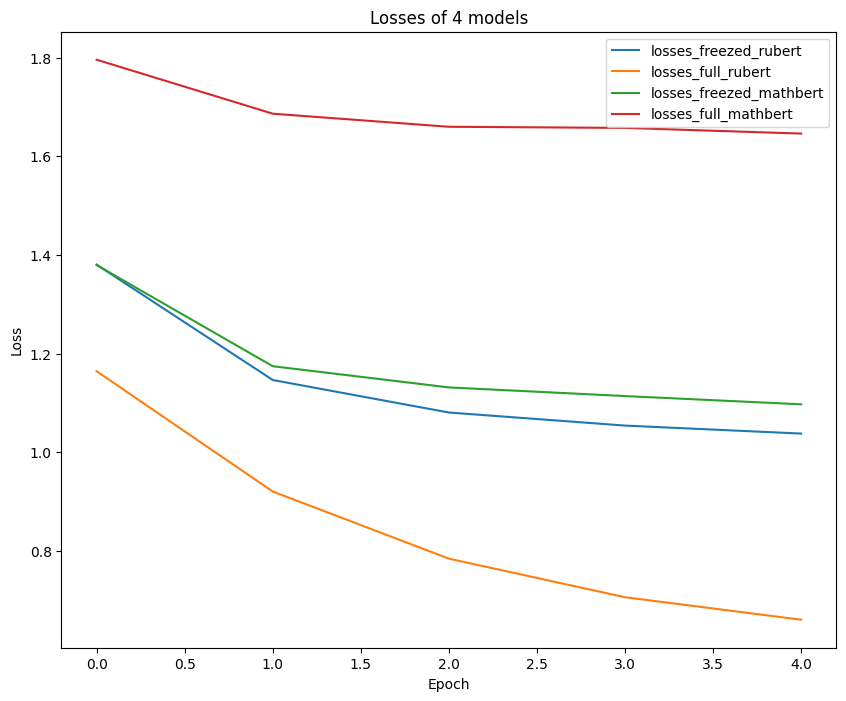

In [87]:
plt.figure(figsize=(10,8))
plt.plot(losses_freezed_rubert, label="losses_freezed_rubert")
plt.plot(losses_full_rubert, label="losses_full_rubert")
plt.plot(losses_freezed_mathbert, label="losses_freezed_mathbert")
plt.plot(losses_full_mathbert, label="losses_full_mathbert")
plt.legend()
plt.title("Losses of 4 models")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.show()

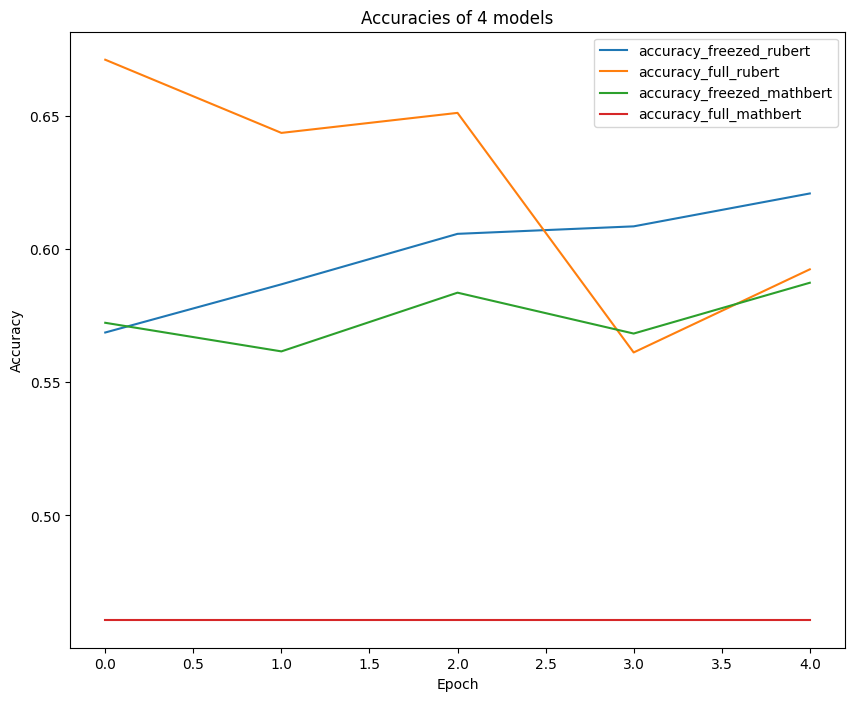

In [90]:
plt.figure(figsize=(10,8))
plt.plot(accuracy_freezed_rubert, label="accuracy_freezed_rubert")
plt.plot(accuracy_full_rubert, label="accuracy_full_rubert")
plt.plot(accuracy_freezed_mathbert, label="accuracy_freezed_mathbert")
plt.plot(accuracy_full_mathbert, label="accuracy_full_mathbert")
plt.legend()
plt.title("Accuracies of 4 models")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.show()

Как мы видим из графиков, после 5 эпох самое лучшее качество получила модель rubert с замороженным backbone. Однако самое высокое качество на протяжении обучения имела модель rubert без заморозки (первые 3 эпохи максимальное значение accuracy). Самый плохой же результат показала модель mathbert без заморозки. Из графиков можно сделать вывод, что rubert обучился лучше, чем mathbert (однако тяжело сравнивать модели, учитывая, что они обучались на разных датасетах)

### Задание 6 (1 балл)

Напишите функцию для отрисовки карт внимания первого слоя для моделей из задания

In [163]:
def draw_first_layer_attention_maps(attention_head_ids, text: str, model: TransformerClassificationModel, ru=False):
    if ru:
        tokenized_text = ru_tokenizer(text,padding=True, truncation=True,
                                      max_length=512, return_tensors="pt")
    else:
        tokenized_text = eng_tokenizer(text,padding=True, truncation=True,
                                       max_length=512, return_tensors="pt")
    input_ids = tokenized_text["input_ids"].to(device)
    attention_mask = tokenized_text["attention_mask"]
    model.eval()
    with torch.no_grad():
        outputs = model.backbone(input_ids, output_attentions=True)
        first_layer_attentions = outputs[0]

    attentions = outputs.attentions

    fig, axes = plt.subplots(1, len(attention_head_ids), figsize=(12, 10))

    for idx, head_id in enumerate(attention_head_ids):
        attention = attentions[0][0, head_id].cpu().numpy()
        ax = axes[idx]
        im = ax.imshow(attention)
        ax.set_title(f'Head {head_id}')
        ax.set_xlabel('Tokens')
        ax.set_ylabel('Tokens')
        ax.set_xticks(range(len(input_ids[0])))
        ax.set_yticks(range(len(input_ids[0])))
        if ru:
            ax.set_xticklabels(ru_tokenizer.convert_ids_to_tokens(input_ids[0]), rotation=90)
            ax.set_yticklabels(ru_tokenizer.convert_ids_to_tokens(input_ids[0]))
        else:
            ax.set_xticklabels(eng_tokenizer.convert_ids_to_tokens(input_ids[0]), rotation=90)
            ax.set_yticklabels(eng_tokenizer.convert_ids_to_tokens(input_ids[0]))

    plt.tight_layout()
    plt.show()

### Задание 7 (1 балл)

Проведите инференс для всех моделей **ДО ДООБУЧЕНИЯ** на 2-3 текстах из датасета. Посмотрите на головы Attention первого слоя в каждой модели на выбранных текстах (отрисуйте их отдельно).

Попробуйте их проинтерпретировать. Какие связи улавливают карты внимания? (если в модели много голов Attention, то проинтерпретируйте наиболее интересные)

In [176]:
ru_samples = train_ru_data.sample(3)["task"].to_list()
eng_samples = train_eng_data.sample(3)["task"].to_list()

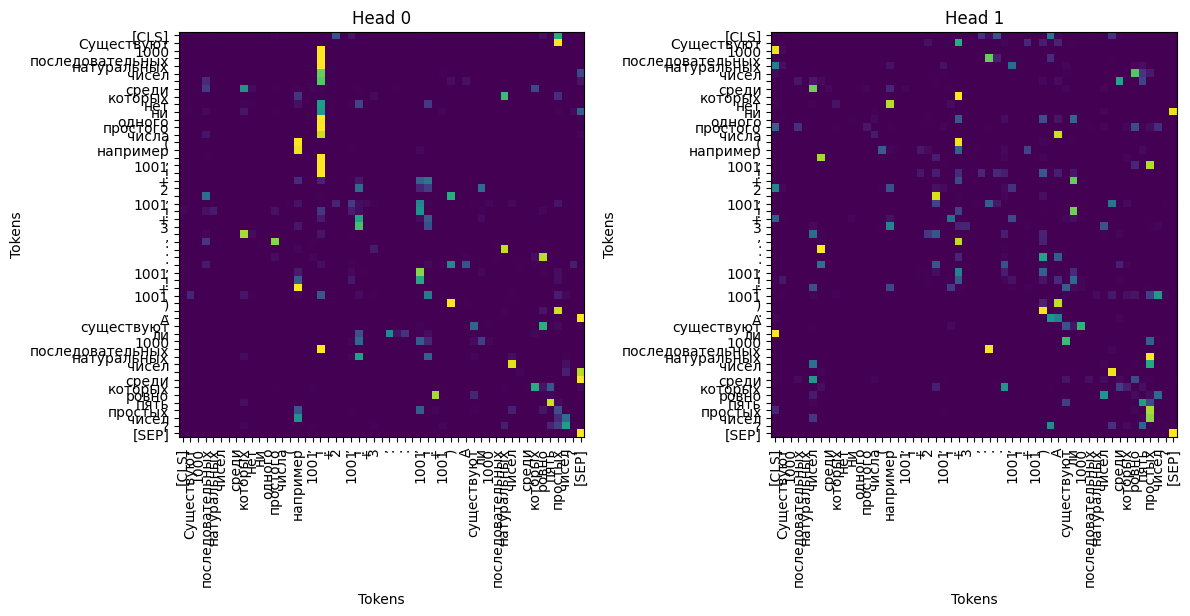

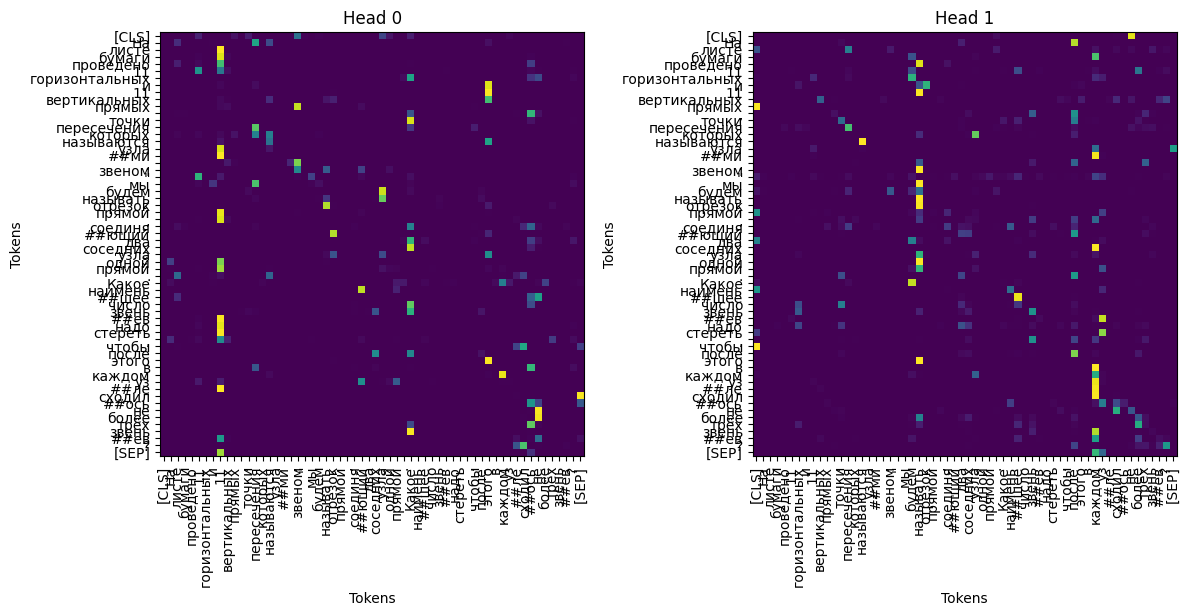

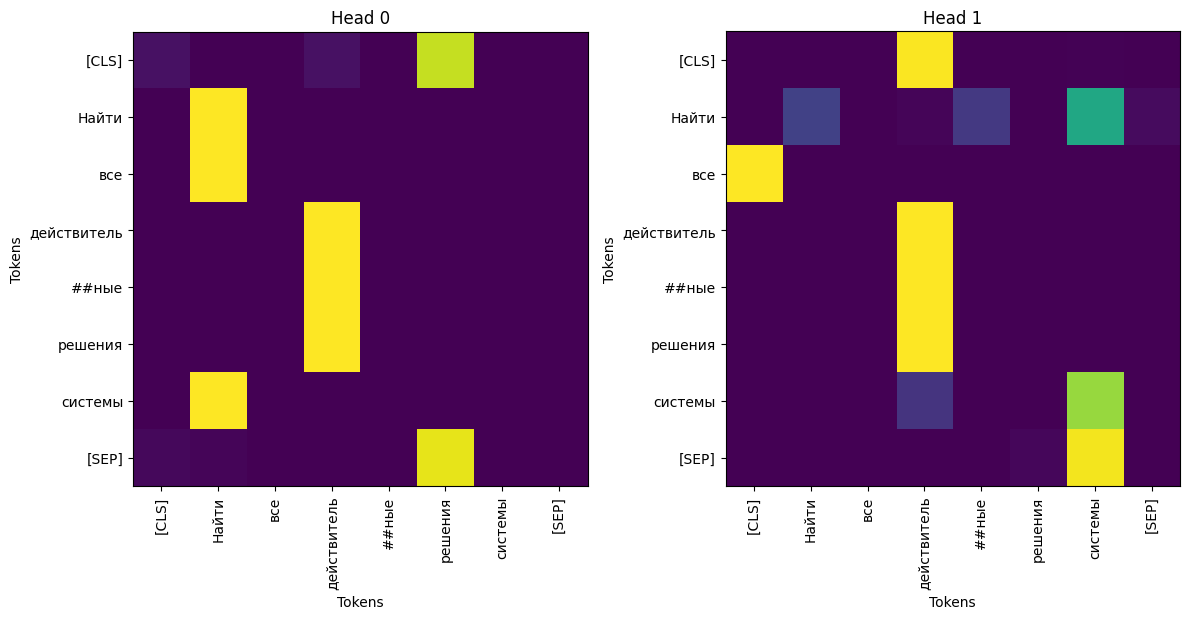

In [178]:
for sample in ru_samples:
    draw_first_layer_attention_maps([0,1], sample, rubert_tiny_transformer_model, ru=True)

В этих примерах видно, как разные головы улавливают разные связи в данных. Например, в третьем примере улавливается связь между _найти_ и _все_, и _действительные_ и _решения_.

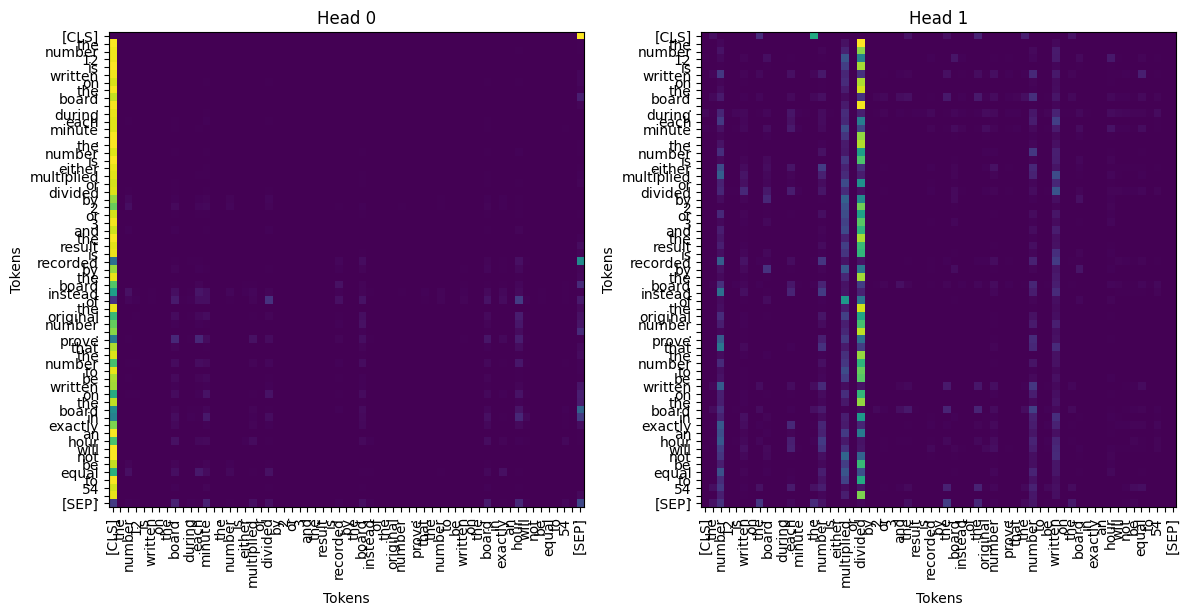

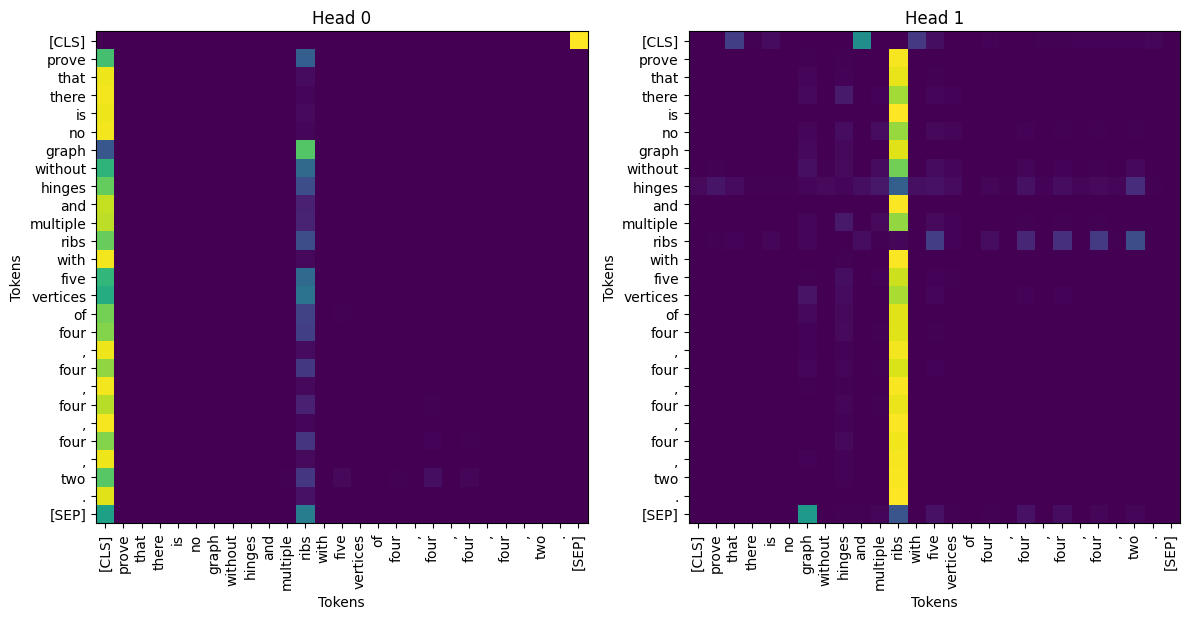

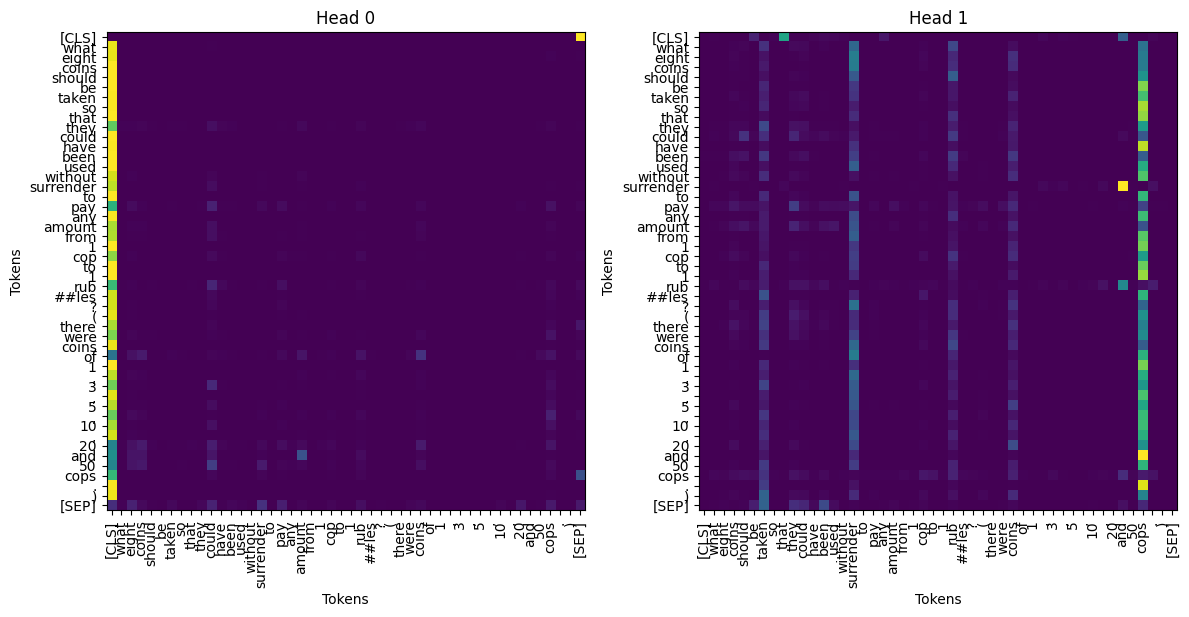

In [177]:
for sample in eng_samples:
    draw_first_layer_attention_maps([0,1], sample, mathbert_transformer_model, ru=False)

В случае с английским языком, необученная модель плохо улавливает связи

### Задание 8 (1 балл)

Сделайте то же самое для дообученных моделей. Изменились ли карты внимания и связи, которые они улавливают? Почему?

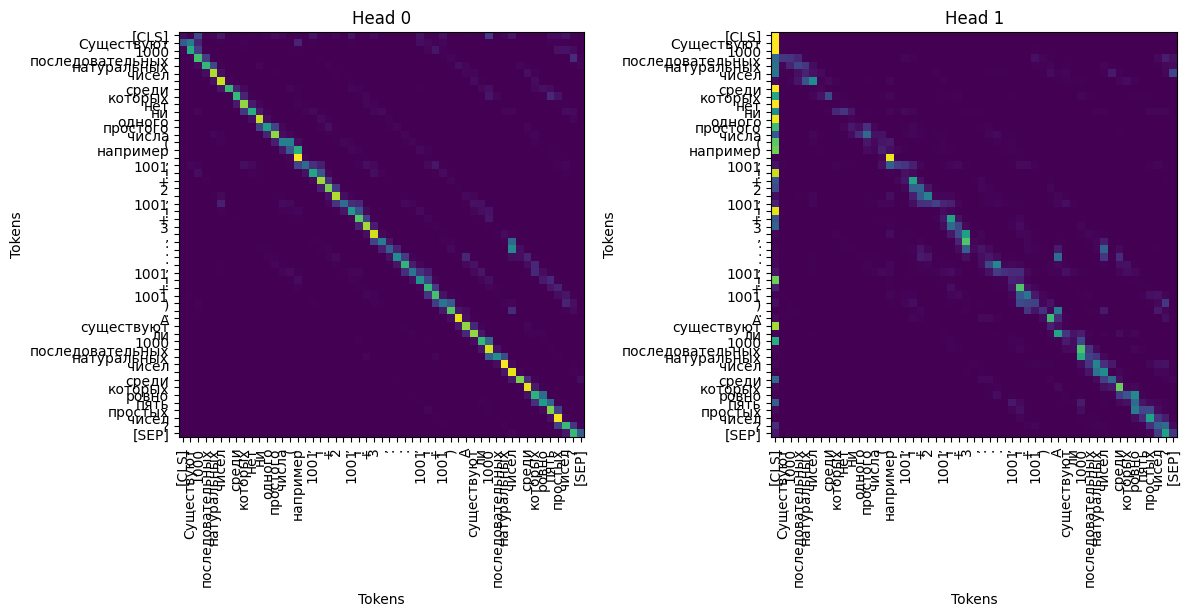

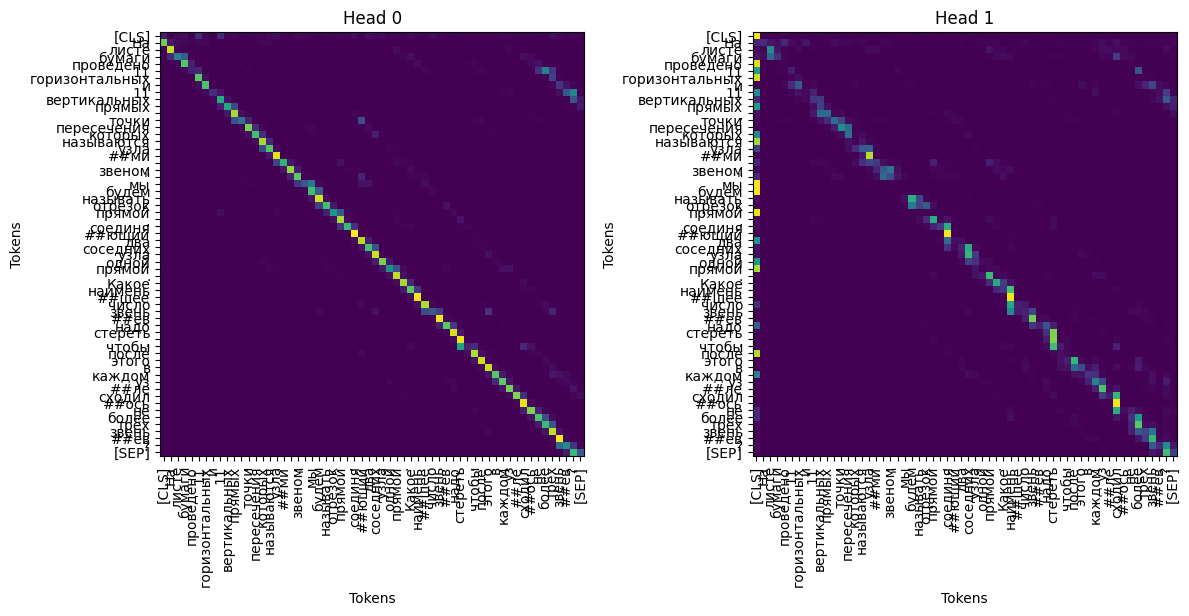

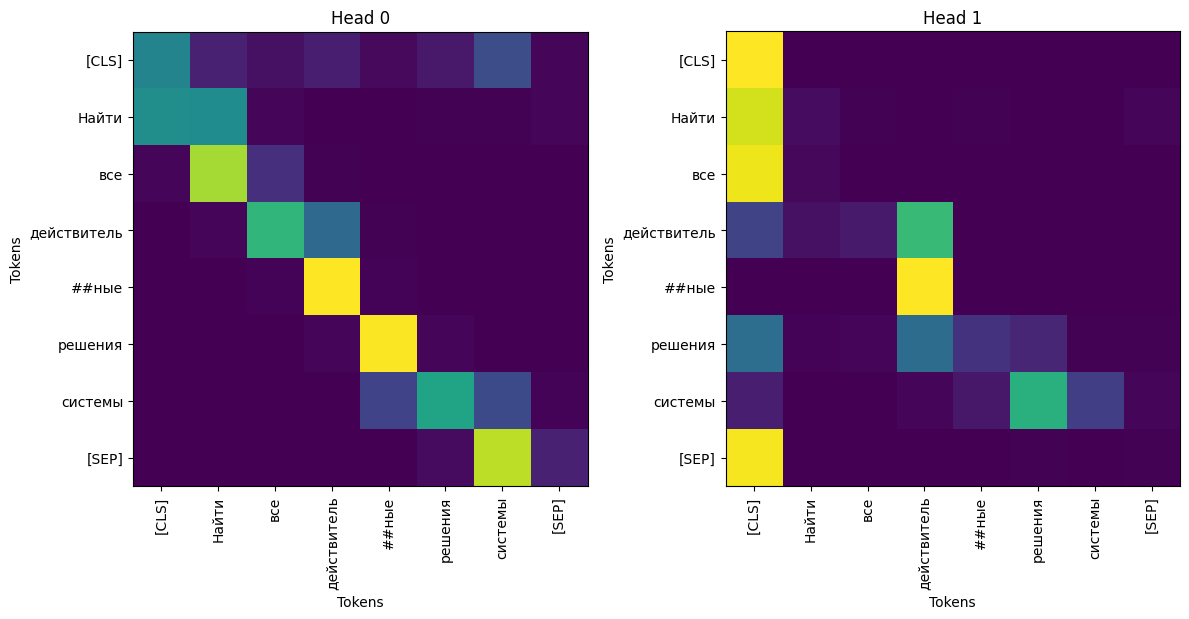

In [179]:
for sample in ru_samples:
    draw_first_layer_attention_maps([0,1], sample, rubert_tiny_finetuned_with_freezed_backbone, ru=True)

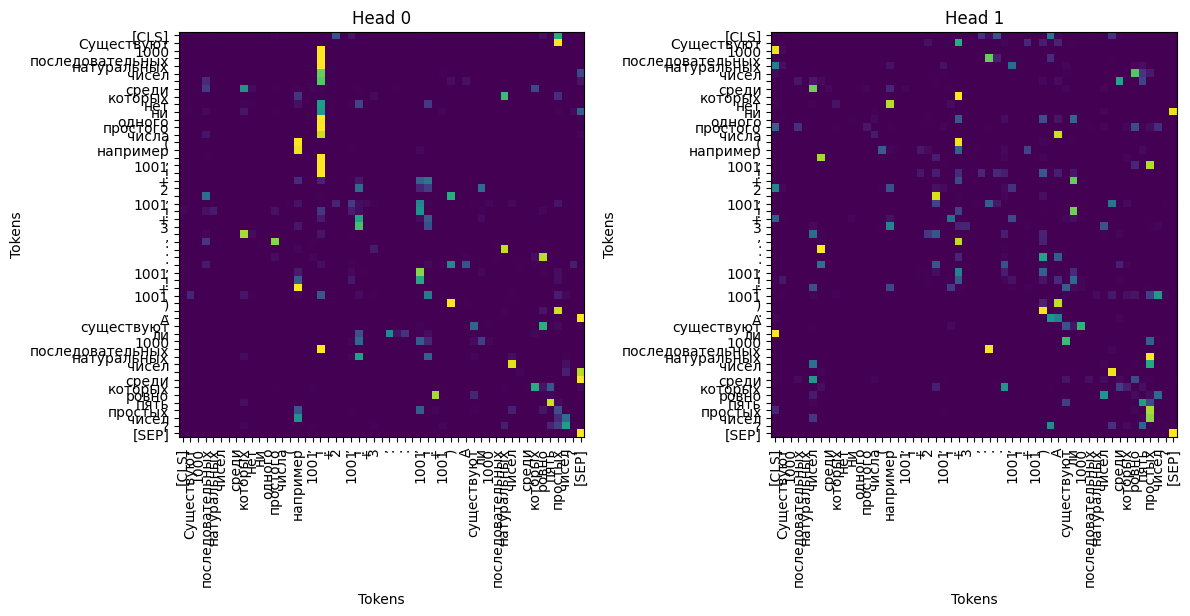

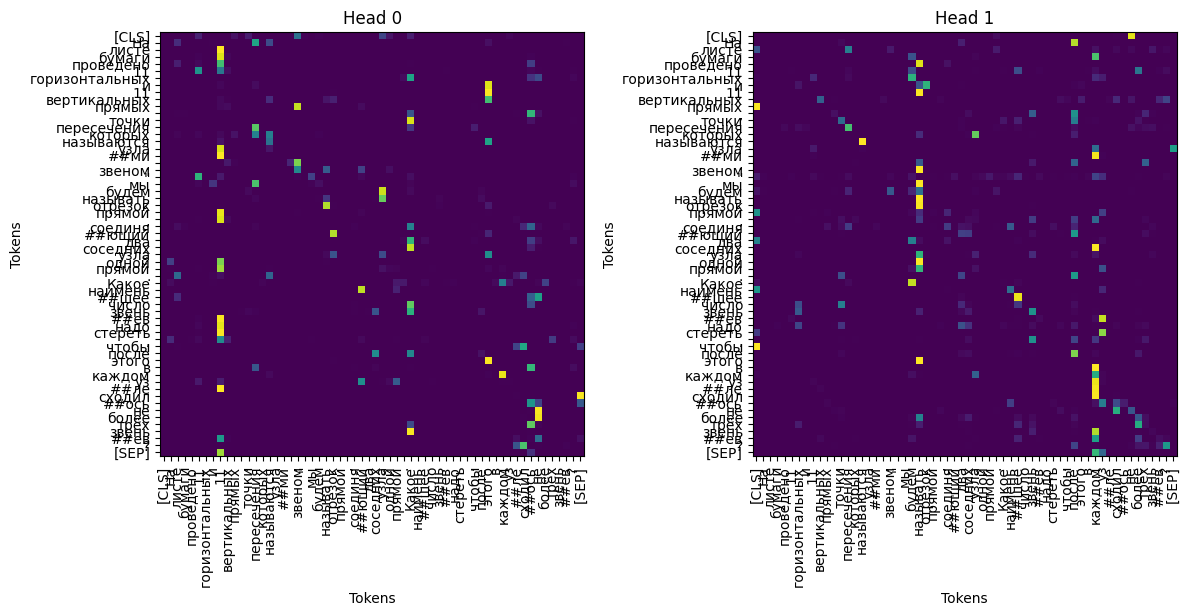

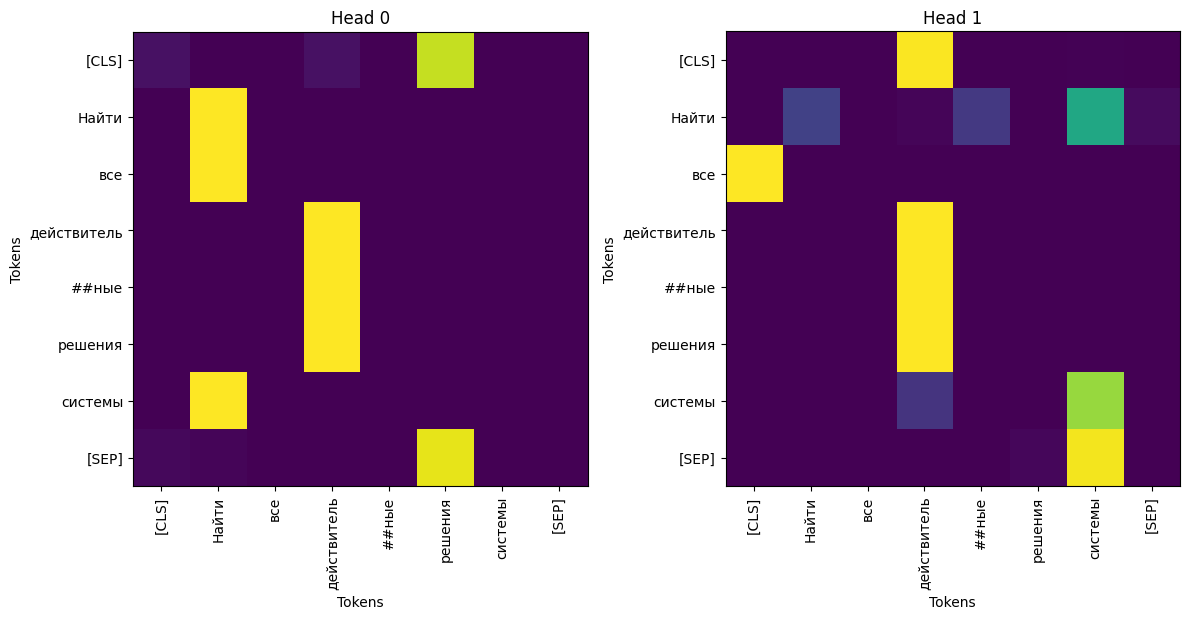

In [180]:
for sample in ru_samples:
    draw_first_layer_attention_maps([0,1], sample, rubert_tiny_full_finetuned, ru=True)

Как видим, обученный rubert начал улавливать новые связи и обращать больше внимания на предыдущие слова

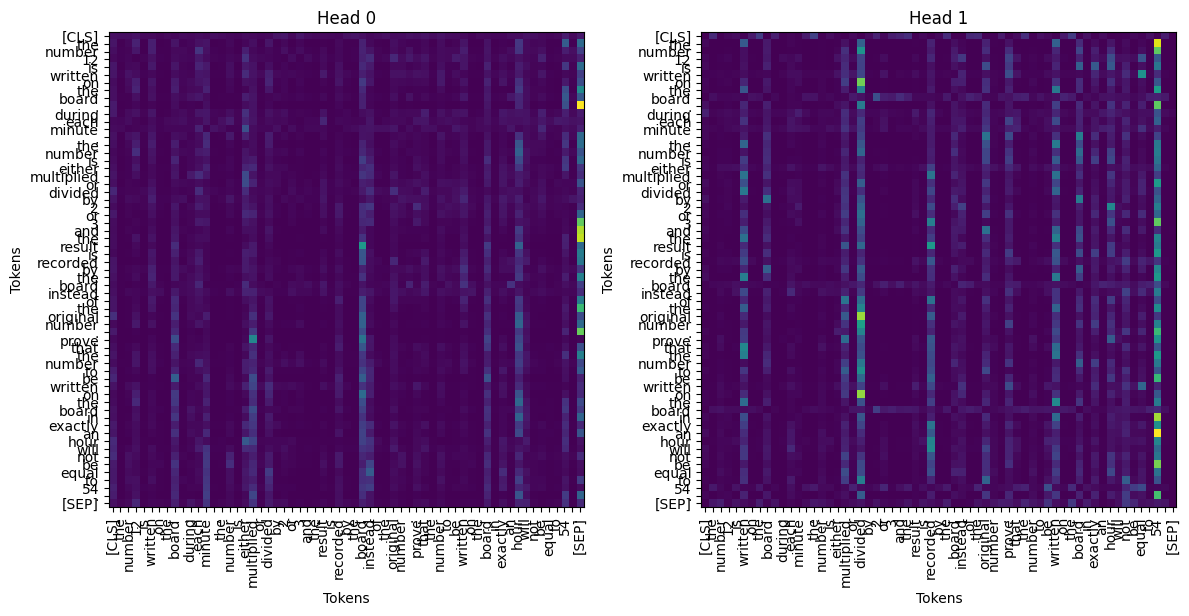

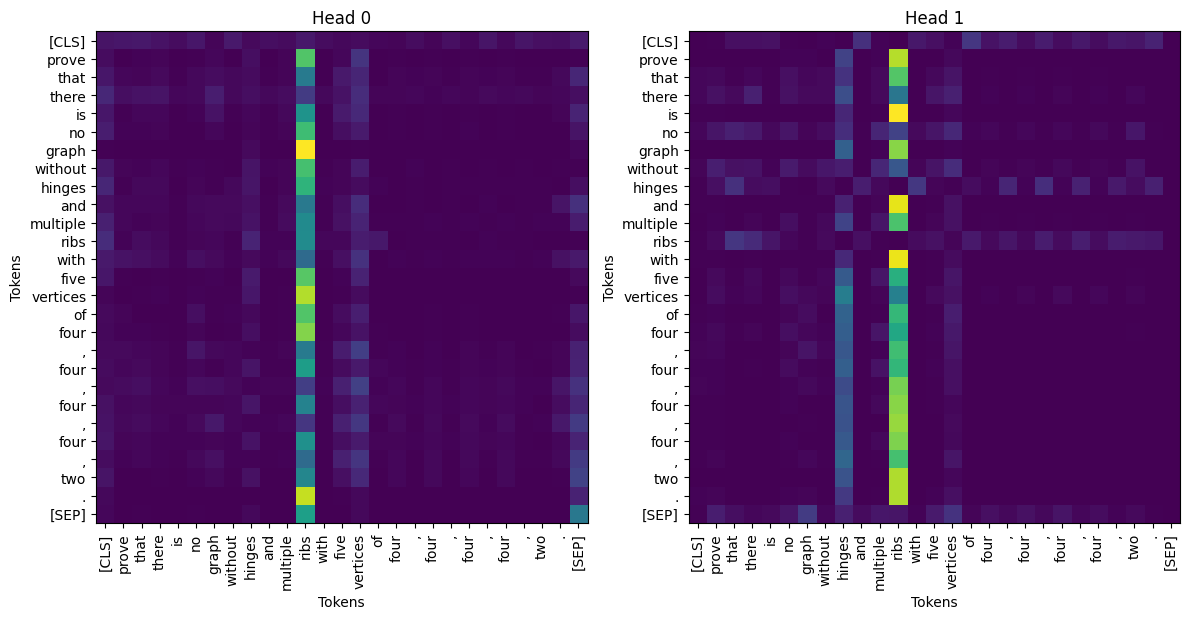

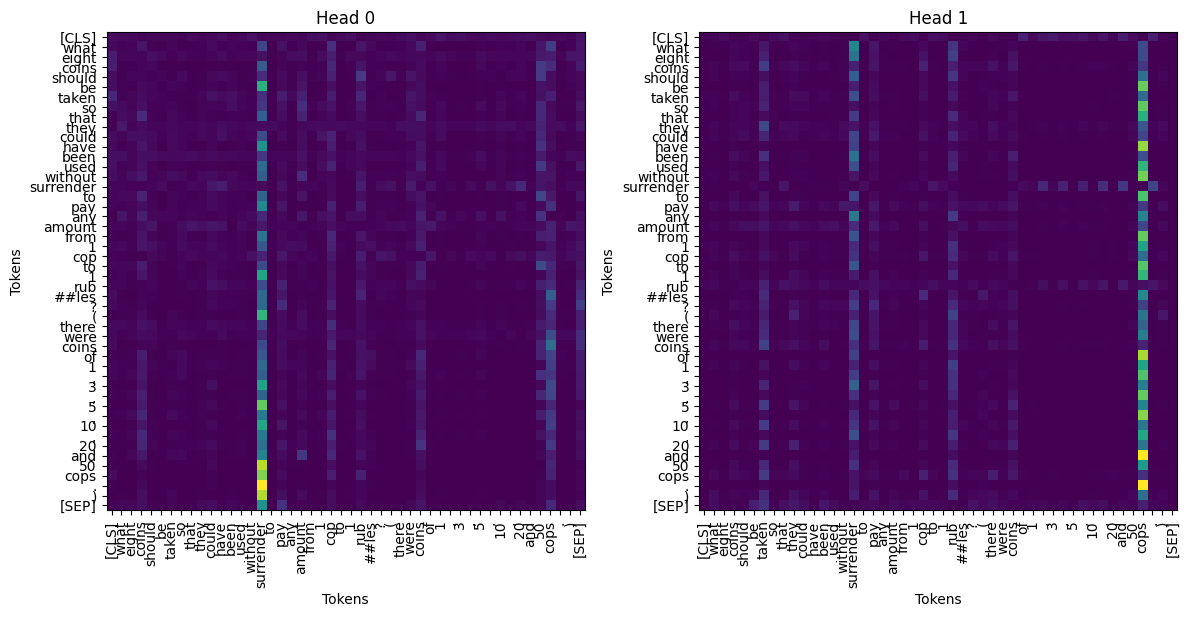

In [181]:
for sample in eng_samples:
    draw_first_layer_attention_maps([0,1], sample, mathbert_finetuned_with_freezed_backbone, ru=False)

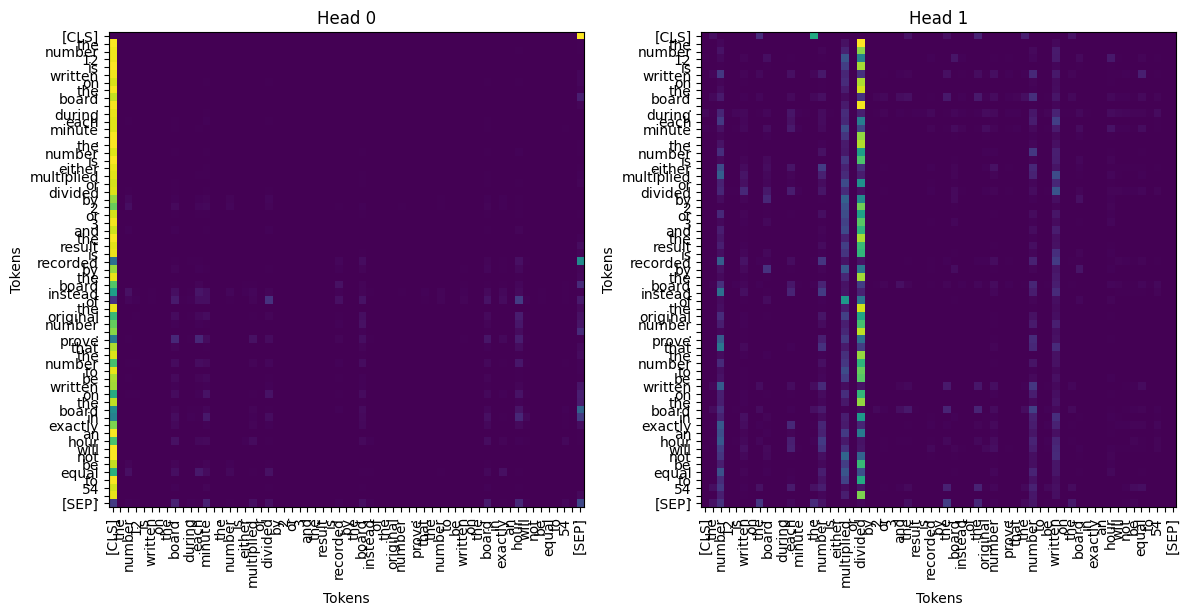

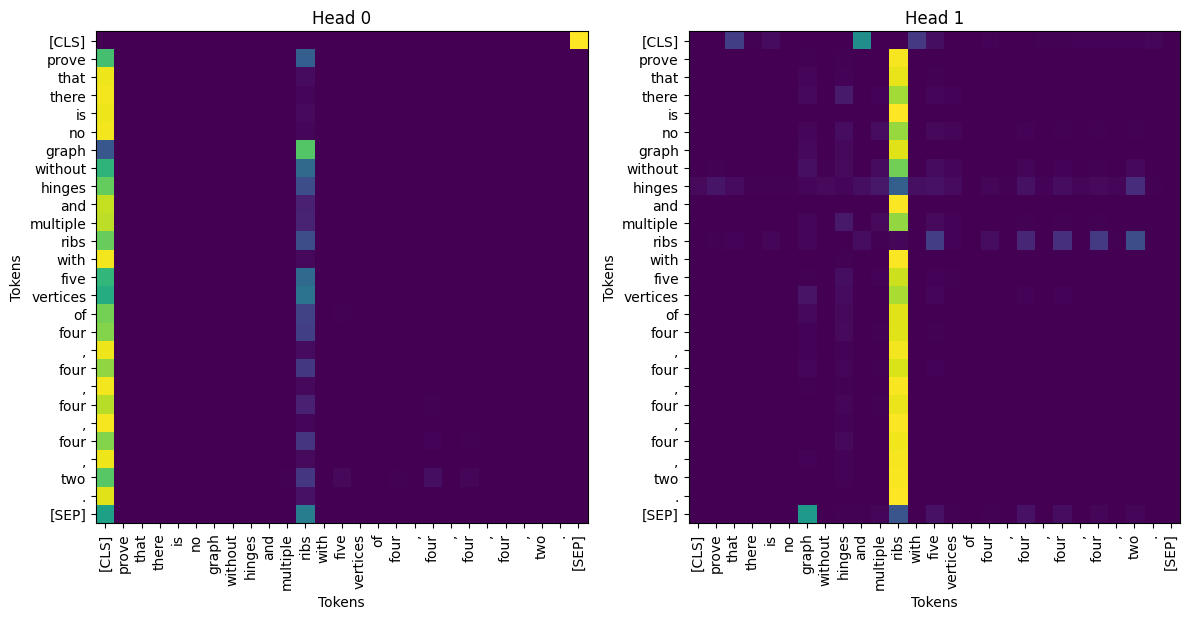

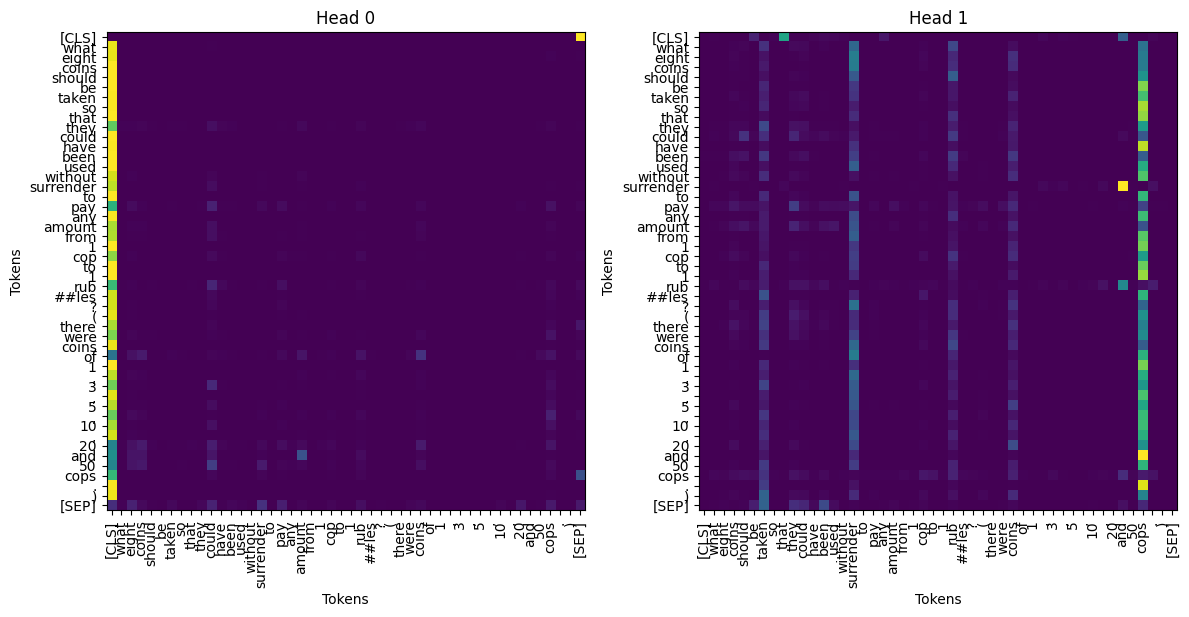

In [182]:
for sample in eng_samples:
    draw_first_layer_attention_maps([0,1], sample, mathbert_full_finetuned, ru=False)

Обученный mathbert начал смотреть немного шире

Но как и видно из этих картинок, чем хуже карты внимания и связи, которые они улавливают, тем и хуже собственно качество самой модели. Самая слабая модель хуже всего улавливает связи, а самая лучшая - качественнее